In [1]:
%load_ext autoreload
%autoreload 2
sys.path.append("..")

from como.logistic_ser import fit_ser
from como.logistic_susie import *

from ser_tests import *
import matplotlib.pyplot as plt
from jax.experimental import sparse

from como.logistic_regression import LogisticSusie
from como.component_distributions import PointMassComponent, NormalFixedLocComponent
from como.twococomo import TwoComponentCoMo

In [2]:
n, p = 1000, 2000
data = sim_ser(n, p, -3, 4)
offset = np.zeros(n)
params, hypers = init_ser(data)

elbo monotone: False, with min change: -0.286773681640625
credible set: [0 1 2 3 4 5 6 7 8 9]
CPU times: user 3.82 s, sys: 114 ms, total: 3.93 s
Wall time: 4.31 s


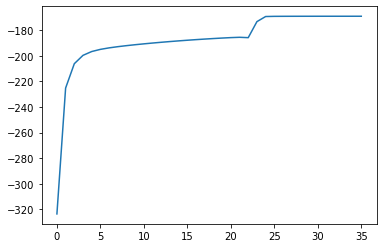

In [3]:
%%time
control = dict(
    update_b = True,
    update_xi = True,
    update_delta = True,
    update_hypers = True,
    track_elbo = True
)
params, hypers, elbo = fit_ser(data, control=control, niter=100, tol=1e-3)
params['mu'].block_until_ready()
plt.plot(elbo)

is_monotone = lambda x: np.alltrue((np.roll(x, -1) - x)[:-1] >=0)
min_delta = lambda x: np.min((np.roll(x, -1) - x)[:-1])

print(f'elbo monotone: {is_monotone(elbo)}, with min change: {min_delta(elbo)}')
print(f'credible set: {get_credible_set(params["alpha"])}')

In [4]:
%%time
n, p = 1000, 5000
L = 10
data = sim_susie(n, p, -4, np.array([2., 4., 6.]))

CPU times: user 137 ms, sys: 12 ms, total: 149 ms
Wall time: 150 ms


elbo monotone: True, with min change: 0.004364013671875


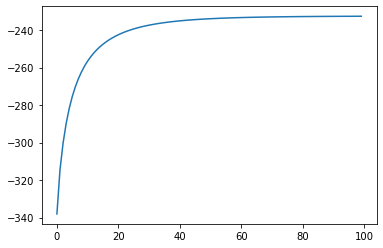

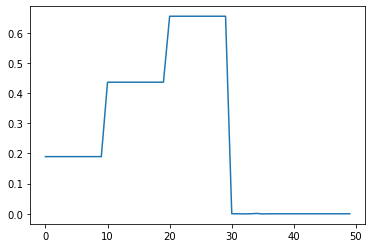

In [5]:
params, hypers, elbo, diff, iter = fit_susie(data, L, 100)
elbo.block_until_ready()
print(f'elbo monotone: {is_monotone(elbo)}, with min change: {min_delta(elbo)}')

plt.plot(elbo); plt.show()
cs = {f'L{k+1}': get_credible_set(params['alpha'][k]) for k in range(L)}
plt.close()

b = Eb_susie(params)
plt.plot(b[:50])

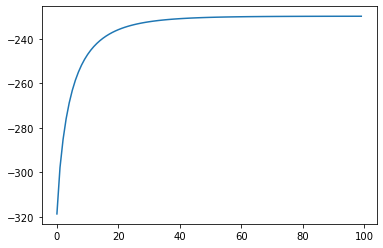

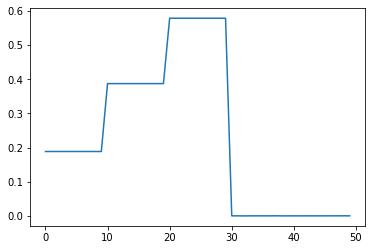

In [12]:
binfit = LogisticSusie(data, L=10)
binfit.freeze()
binfit.thaw()

elbo = []
for i in range(100):
    binfit.update()
    elbo.append(binfit.evidence())

plt.plot(elbo); plt.show()
cs = {f'L{k+1}': get_credible_set(binfit.params['alpha'][k]) for k in range(L)}
plt.close()

b = Eb_susie(binfit.params)
plt.plot(b[:50])

In [13]:
f0 = PointMassComponent(5)
f1 = NormalFixedLocComponent(5, 1.)

print(f0.convolved_logpdf(np.linspace(0, 10, 20), np.ones(20)))
print(f1.convolved_logpdf(np.linspace(0, 10, 20), np.ones(20)))

[-13.418939  -10.925864   -8.709797   -6.7707386  -5.1086893  -3.7236476
  -2.6156142  -1.7845895  -1.2305727  -0.9535645  -0.9535645  -1.2305727
  -1.7845898  -2.6156147  -3.7236476  -5.1086893  -6.77074    -8.709798
 -10.925864  -13.418939 ]
[-7.5155125 -6.2689753 -5.1609416 -4.1914124 -3.3603878 -2.6678667
 -2.11385   -1.6983376 -1.4213293 -1.2828251 -1.2828251 -1.4213293
 -1.6983378 -2.11385   -2.6678667 -3.3603878 -4.191413  -5.160942
 -6.2689753 -7.5155125]


In [14]:
from como.logistic_regression import LogisticSusie

n, p = 1000, 5000
L = 4
data = sim_susie(n, p, -4, np.array([2., 4., 6.]))
data.keys()

dict_keys(['y', 'p', 'X', 'Z', 'params'])

In [15]:
%%time
logistic_susie = LogisticSusie(data)
elbo_susie(
    logistic_susie.data,
    logistic_susie.params,
    logistic_susie.hypers
)
for i in range(100):
    logistic_susie.update()
    elbo_susie(logistic_susie.data, logistic_susie.params, logistic_susie.hypers)

logistic_susie.report_credible_sets()

CPU times: user 5.57 s, sys: 514 ms, total: 6.09 s
Wall time: 5.41 s


{'L1': DeviceArray([20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32),
 'L2': DeviceArray([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32),
 'L3': DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 'L4': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L5': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L6': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L7': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L8': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L9': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32),
 'L10': DeviceArray([2719,  442,  642, ..., 2736,  493, 2275], dtype=int32)}

In [16]:
def sim_sumstat_susie(n, p, b0, b, scale=1):
    #mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None]) / 3)
    #X = np.random.binomial(1, 0.2, size=n*p).reshape(n, -1) @ mix
    X = np.random.normal(size=n*p).reshape(n, -1) #@ mix
    X[:, :9] = X[:, 9][:, None]
    X[:, 10:19] = X[:, 19][:, None]
    X[:, 20:29] = X[:, 29][:, None]
    
    logits = b0 + X[:, [9, 19, 29]] @ b
    p = jnp.clip(sigmoid(b0 + X[:, [9, 19, 29]] @ b), 1e-8, 1-1e-8)
    # p = jnp.clip(sigmoid(logits), 1e-8, 1-1e-8)

    y = np.random.binomial(1, p)
    se = np.random.uniform(1, 5, size=n)
    beta = y * np.random.normal(size=n) * scale
    beta_hat = beta + np.random.normal(size=n)* se

    data = {
        'beta_hat': beta_hat,
        'beta': beta,
        'se': se,
        'y': y,
        'p' : p,
        'logits': logits,
        'X': X,
        'Z': np.ones((n, 1)),
        'params': dict(b0=b0, b=b)
    }
    return data

Below we simulate from the covariate moderated two component model.

In [17]:
def binarize_sim(sim, z_thresh):
    y = (np.abs(sim['beta_hat'] / sim['se']) > z_thresh).astype(float)
    return y

def cs_plot(fit):
    for l in range(fit.L):
        alpha = fit.params['alpha'][l]
        cs = get_credible_set(alpha)
        plt.scatter(cs, alpha[cs])

def fit_and_plot(fit, niter=100):
    elbos = [fit.elbo()]
    diff = lambda x: x[-1].get('total_elbo') - x[-2].get('total_elbo')

    for i in range(niter):
        fit.update_responsibilities()
        elbos.append(fit.elbo())

        fit.logreg.update()
        elbos.append(fit.elbo())

        fit.f0.update()
        fit.f1.update()

    import pandas as pd
    elbo_df = pd.DataFrame(elbos)
    print(is_monotone(elbo_df.total_elbo))

    fig, ax = plt.subplots(1, 3)
    ax[0].plot(elbo_df.total_elbo)  # elbo

    binfit = fit.logreg
    plt.sca(ax[1])
    cs_plot(binfit)  # credible sets
    ax[2].scatter(binfit.predict(), sim['logits'])  # prediction vs truth
    plt.show()

    # fig, ax = plt.subplots(2, 2)
    # ax[0, 0].plot(elbo_df.data_loglik)
    # ax[0, 1].plot(elbo_df.assignment_entropy)
    # ax[1, 0].plot(elbo_df.logistic_elbo)
    # ax[1, 1].plot(elbo_df.total_elbo)
    # plt.show(); plt.close()

    # binfit = fit.logreg
    # b = Eb_susie(binfit.params)
    # plt.plot(b[:50]); plt.show(); plt.close()
    # plt.scatter(binfit.predict(), sim['logits'])


def fit_and_plot_logstic(sim, thresh):
    data_logreg = dict(
        y=binarize_sim(sim, thresh), X=sim['X'], Z=sim['Z']
    )
    binfit = LogisticSusie(data_logreg, L=10)
    elbo = []
    for i in range(100):
        binfit.update()
        elbo.append(binfit.evidence())

    fig, ax = plt.subplots(1, 3)
    ax[0].plot(elbo)

    plt.sca(ax[1])
    cs_plot(binfit)
    ax[2].scatter(binfit.predict(), sim['logits'])
    plt.show()

When we fit the logistic model with the true binary status of each observation, we do great! The problem is we don't usually get to observe this.

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics

def plot_pr_roc(y_true, pred, ax1=None, ax2=None):
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    fpr, tpr, _ = roc_curve(y_true, pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr);

    prec, recall, _ = precision_recall_curve(y_true, pred, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall);

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()


def plot_roc(y_true, preds, labels):
    for pred, label in zip(preds, labels):
        fpr, tpr, _ = metrics.roc_curve(y_true, pred)
        auc = round(metrics.roc_auc_score(y_true, pred), 4)
        plt.plot(fpr,tpr,label=f"{label}, AUC="+str(auc))
    plt.legend()

In [251]:
n = 5000
p = 100
sim = sim_sumstat_susie(n, p, -2, np.array([1., 2., 3.,]), scale=4)

fit_data = dict(
    beta = sim['beta_hat'],
    se = sim['se'],
    X = sim['X'],
    Z = sim['Z']
)

y_true = sim['y']


In [771]:
fit_data['Z']

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

Coverged: True Monotone ELBO: True
Final scale: 10
Final pi0: 0.5


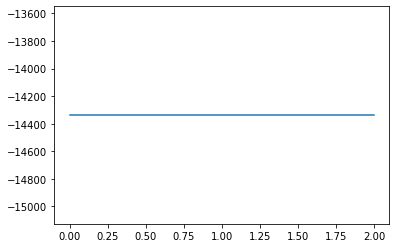

In [285]:
from como.component_distributions import NormalFixedLocComponent
from como.twococomo import PointNormal, PointNormalSuSiE

# point-normal, fixed intercept
tol = 1e-3
fit0a = PointNormal(fit_data, 10)
fit0a.f1.freeze()
fit0a.logreg.freeze()

fit0a.fit(niter=1000)

print(f'Coverged: {fit0a.converged(tol)}\
 Monotone ELBO: {is_monotone(fit0a.elbo_history)}')
print(f'Final scale: {fit0a.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit0a.logreg.intercept))}')
plt.plot(fit0a.elbo_history)

Coverged: True Monotone ELBO: True
Final scale: 10
Final pi0: 0.8964679659629757


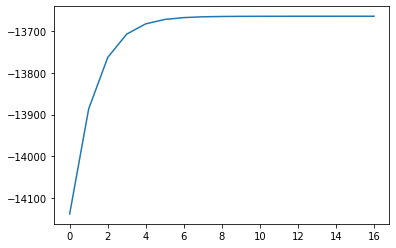

In [286]:
# point normal-- estimated intercept
tol = 1e-3
fit0b = PointNormal(fit_data, 10)
fit0b.f1.freeze()  # don't estimate scale
fit0b.fit(niter=1000)

print(f'Coverged: {fit0b.converged(tol)}\
 Monotone ELBO: {is_monotone(fit0b.elbo_history)}')
print(f'Final scale: {fit0b.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit0b.logreg.intercept))}')
plt.plot(fit0b.elbo_history)

Coverged: True Monotone ELBO: True
Final scale: 3.299999952316284
Final pi0: 0.5


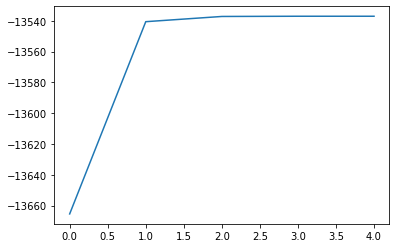

In [287]:
# fix intercept, estimate scale
tol = 1e-3
fit0c = PointNormal(fit_data, 1)
fit0c.f1.thaw()
fit0c.logreg.freeze()
fit0c.fit(niter=1000)

print(f'Coverged: {fit0c.converged(tol)}\
 Monotone ELBO: {is_monotone(fit0c.elbo_history)}')
print(f'Final scale: {fit0c.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit0c.logreg.intercept))}')
plt.plot(fit0c.elbo_history)

Coverged: True Monotone ELBO: True
Final scale: 4.099999904632568
Final pi0: 0.69786947895669


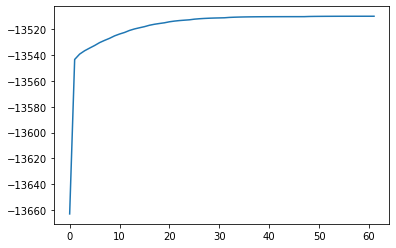

In [288]:
# estimate intercept, estimate scale
tol = 1e-3
fit0d = PointNormal(fit_data, 1)
fit0d.f1.thaw()
fit0d.fit(niter=1000)

print(f'Coverged: {fit0d.converged(tol)}\
 Monotone ELBO: {is_monotone(fit0d.elbo_history)}')
print(f'Final scale: {fit0d.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit0d.logreg.intercept))}')
plt.plot(fit0d.elbo_history)

Coverged: True Monotone ELBO: True
Final scale: 10.0
Final pi0: 0.9499257641185832


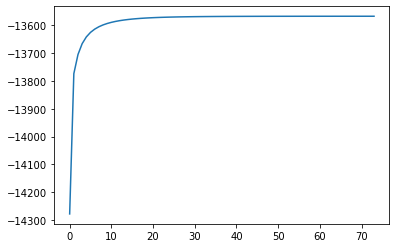

In [289]:
# include covariates, fix scale
fit1 = PointNormalSuSiE(fit_data, 10.0)
fit1.f1.freeze()
fit1.fit(niter=1000)

print(f'Coverged: {fit1.converged(tol)}\
 Monotone ELBO: {is_monotone(fit1.elbo_history)}')
print(f'Final scale: {fit1.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit1.logreg.intercept))}')
plt.plot(fit1.elbo_history)

Coverged: True Monotone ELBO: True
Final scale: 4.199999809265137
Final pi0: 0.9029701999383573


228

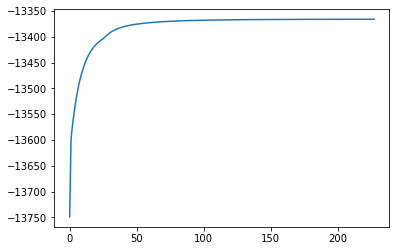

In [354]:
# include covariates, estimate scale
fit2 = PointNormalSuSiE(fit_data, 1.0)
# fit2.f1.thaw()
fit2.fit(niter=1000)


print(f'Coverged: {fit2.converged(tol)}\
 Monotone ELBO: {is_monotone(fit2.elbo_history)}')
print(f'Final scale: {fit2.f1.scale}')
print(f'Final pi0: {1/(1 + np.exp(fit2.logreg.intercept))}')
plt.plot(fit2.elbo_history)
np.array(fit2.elbo_history).size

In [539]:
from como.twococomo import UnimodalNormalMixtureSuSiE

# include covariates, estimate scale
fit3 = UnimodalNormalMixtureSuSiE(fit_data)

fit3.elbo(record=True)
# fit2.f1.thaw()

for i in range(1):
    fit3.update_responsibilities()
    fit3.elbo(record=True)
    if fit3.converged():
        print('r'); break

    fit3.logreg.update()
    fit3.elbo(record=True)
    if fit3.converged():
        print('l'); break

    #fit3.f1.update(fit3.data)
    #fit3.elbo(record=True)
    #if fit3.converged():
    #    print(f'iter {i}: f'); break

In [766]:
from como.component_distributions import *

scales = np.array([2., 4., 8., 16., 32.]) 
pi_true = np.array([3, 3, 2, 2, 1]) / 11.
n = 1000
se = 1.0 * np.ones(n)

sample_scales = np.random.choice(scales, size = n, replace=True, p=pi_true)
sample_beta = np.random.normal(size = n) * sample_scales
sample_beta_hat = sample_beta + (np.random.normal(size=n) * se)

beta = sample_beta_hat
se = se
loc = 0.0
eta = np.zeros(scales.size - 1)
#eta = np.random.normal(size=scales.size - 1)

update = lambda a: newtonNSM(beta, se, loc, scales, a)
loss = lambda a: lossNSM(beta, se, loc, scales, a)

print(loss(eta))
print(loss(update(eta)))
print(loss(update(update(eta))))

-7057.0723
-6455.0664
-6546.8135


In [763]:
eta = update(eta)
ng = jnp.linalg.solve(
    hessNSM(beta, se, loc, scales, eta), 
    gradNSM(beta, se, loc, scales, eta)
)
print(f'pi: {eta2pi(eta)}\nloss: {loss(eta)}')

pi: [0.00714936 0.9522224  0.01345192 0.01309753 0.01407879]
loss: -6791.5693359375


In [768]:
!which python

/usr/local/Caskroom/miniconda/base/bin/python


In [556]:
from como.component_distributions import lossNSM
a = lossNSM(
    fit3.data['beta'],
    fit3.data['se'],
    0,
    fit3.f1.scales,
    fit3.f1.eta,
    fit3.data['y'])

eta_new = newtonNSM(
    fit3.data['beta'],
    fit3.data['se'],
    0,
    fit3.f1.scales,
    fit3.f1.eta,
    fit3.data['y'])
fit3.f1.eta = eta_new

b = lossNSM(
    fit3.data['beta'],
    fit3.data['se'],
    0,
    fit3.f1.scales,
    eta_new,
    fit3.data['y'])

a < b

DeviceArray(True, dtype=bool)

Coverged: True Monotone ELBO: False
Final pi: [4.0400824e-08 4.1138453e-08 4.4357240e-08 6.3326119e-08 9.7298062e-01
 9.9639164e-10 3.1506575e-09 3.3958134e-09 4.1403378e-10 2.7019275e-02]
Final pi0: 0.46541885604253314


14

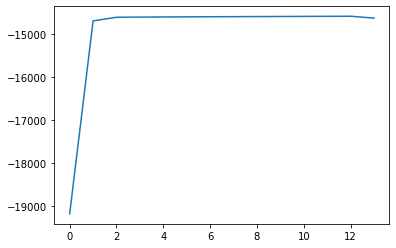

In [520]:
print(f'Coverged: {fit3.converged(tol)}\
 Monotone ELBO: {is_monotone(fit3.elbo_history)}')
print(f'Final pi: {fit3.f1.pi}')
print(f'Final pi0: {1/(1 + np.exp(fit3.logreg.intercept))}')
plt.plot(fit3.elbo_history)
np.array(fit3.elbo_history).size

(array([2654.,  408.,  274.,  202.,  155.,  129.,  149.,  168.,  187.,
         674.]),
 array([3.0645407e-07, 1.0000028e-01, 2.0000024e-01, 3.0000022e-01,
        4.0000018e-01, 5.0000018e-01, 6.0000014e-01, 7.0000011e-01,
        8.0000007e-01, 9.0000004e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

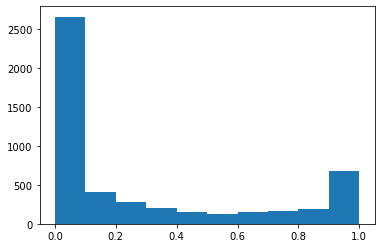

In [353]:
plt.hist(np.array(fit2.responsibilities))

In [327]:
from como.twococomo import twococomo_loglik

def temp_elbo(data, f0, f1, logreg):
    responsibilities = data['y']
    data_loglik = twococomo_loglik(data, responsibilities, f0, f1, sum = False)
    assignment_entropy =  -(responsibilities * jnp.log(responsibilities))
    
    # susie_loglik = loglik_susie(logreg.data, logreg.params)
    # Xb = Xb_susie(logreg.data, logreg.params)
    susie_loglik = loglik_susie(logreg.data, logreg.params) # logreg.data['y'] * Xb
    kl = susie_kl(logreg.params, logreg.hypers)
    total_elbo = jnp.sum(data_loglik + assignment_entropy + susie_loglik) - kl
    return dict(
        data_loglik=data_loglik,
        assignment_entropy=assignment_entropy,
        susie_loglik=susie_loglik,
        kl=kl,
        #logistic_elbo=logreg_elbo,
        part_elbo= data_loglik + assignment_entropy + susie_loglik,
        total_elbo=total_elbo)

fit2 = PointNormalSuSiE(fit_data, 1.0)

elbo_before = []
elbo_after = []
for _ in range(10):
    elbo_before.append(temp_elbo(
        fit2.data, fit2.f0, fit2.f1, fit2.logreg))
    fit2.update_responsibilities()
    elbo_after.append(temp_elbo(
        fit2.data, fit2.f0, fit2.f1, fit2.logreg))
    fit2.iter()


array([1.        , 0.71419996, 0.7978    , 0.80259997, 0.8092    ,
       0.8596    , 0.84739995, 0.89479995, 0.88159996, 0.92499995],
      dtype=float32)

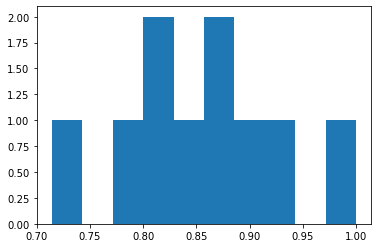

In [328]:
prop_improved = lambda e1, e2: jnp.mean(e2['part_elbo'] >= e1['part_elbo'])
x = np.array([prop_improved(elbo_before[i], elbo_after[i]) for i in range(10)])
plt.hist(x)
x

In [329]:
# useful
logit = lambda x: np.log(x + 1e-20) - np.log(1 - x + 1e-20)
sigmoid = lambda x: 1 / (1 + jnp.exp(-x))

# ELBO reduced to terms dependent on responsibilities
def gamma_objective(beta, se, logits, Xb, f0, f1):
    # compute data likelihood under each component
    f0_loglik = f0.convolved_logpdf(beta, se)
    f1_loglik = f1.convolved_logpdf(beta, se)
    r = sigmoid(logits)
    loglik = (1 - r) * f0_loglik + r * f1_loglik

    # assignment entropy
    entropy = -(r * jnp.log(r) + (1-r) * jnp.log(1-r))

    # susie likelihood
    susie_loglik = r * Xb # + (1 - r) * (-Xb)

    return loglik + susie_loglik + entropy

# coordinate ascent update for gamma
def gamma_update(beta, se, Xb, f0, f1):
    f0_loglik = f0.convolved_logpdf(beta, se)
    f1_loglik = f1.convolved_logpdf(beta, se) 
    logit_pi = Xb
    logits = f1_loglik - f0_loglik + logit_pi
    return logits


# gradient based optimization of gamma
L = lambda x: gamma_objective(beta[idx], se[idx], x, Xb[idx], fit2.f0, fit2.f1)
gradL = jax.grad(L)
hessL = jax.grad(gradL)
optL = lambda x: x - gradL(x) / hessL(x)

def gamma_optimize (logit):
    for _ in range(10):
        logit = optL(logit)
    return logit

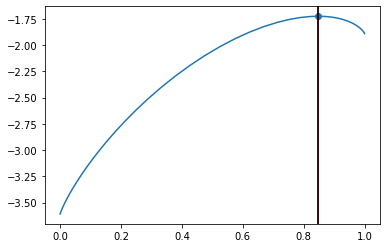

In [330]:

idx = 4141
Xb = Xb_susie(fit2.logreg.data, fit2.logreg.params)
beta = fit2.data['beta']
se = fit2.data['se']

fit2.update_responsibilities()
logits = logit(fit2.data['y'])

x = np.linspace(-10, 10, 100)
plt.plot(sigmoid(x), L(x))

r = fit2.responsibilities[idx]
plt.scatter(r, L(logit(r)))

gamma_new = gamma_update(beta, se, Xb, fit2.f0, fit2.f1)[idx]
plt.axvline(sigmoid(gamma_new), color='red')


gamma_opt = gamma_optimize(gamma_new)
plt.axvline(sigmoid(gamma_opt), color='k')



In [331]:
# vectorized 
vL = gamma_objective
gradL = jax.grad(vL, argnums=2)
hessL = jax.hessian(vL, argnums=2)
newtonL = lambda beta, se, logits, Xb, f0, f1: logits - \
    gradL(beta, se, logits, Xb, f0, f1) / hessL(beta, se, logits, Xb, f0, f1)

vnewtonL = vmap(newtonL, in_axes=(0, 0, 0, 0, None, None), out_axes=0)

vnewtonL(beta, se, logits, Xb, fit2.f0, fit2.f1)

def v_gamma_optimize (logits):
    for _ in range(10):
        logits = vnewtonL(beta, se, logits, Xb, fit2.f0, fit2.f1)
    return logits

In [332]:
%%timeit
logits_new = v_gamma_optimize(logits)

468 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [300]:
%%timeit
logits_new = gamma_update(beta, se, Xb, fit2.f0, fit2.f1)

63 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [333]:
loss_init = vL(beta, se, logits, Xb, fit2.f0, fit2.f1)
fit2.data['y'] = sigmoid(logits)
elbo_init = temp_elbo(fit2.data, fit2.f0, fit2.f1, fit2.logreg)

logits_opt = v_gamma_optimize(logits)
loss_opt = vL(beta, se, logits_opt, Xb, fit2.f0, fit2.f1)

fit2.data['y'] = sigmoid(logits_opt)
elbo_opt = temp_elbo(fit2.data, fit2.f0, fit2.f1, fit2.logreg)

logits_update = gamma_update(beta, se, Xb, fit2.f0, fit2.f1)
loss_update = vL(beta, se, logits_update, Xb, fit2.f0, fit2.f1)
fit2.data['y'] = sigmoid(logits_update)
elbo_update = temp_elbo(fit2.data, fit2.f0, fit2.f1, fit2.logreg)

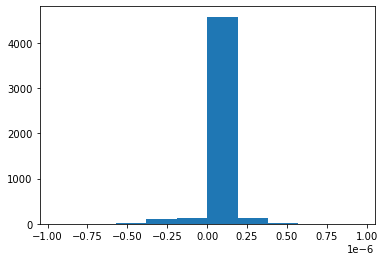

In [334]:
plt.hist(np.array(loss_opt - loss_init));

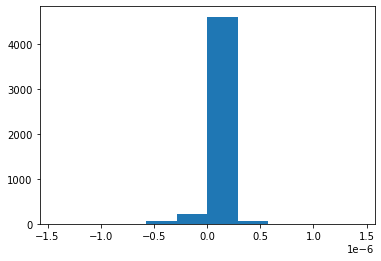

In [303]:
plt.hist(np.array(elbo_opt['part_elbo'] - elbo_update['part_elbo']));

In [335]:
mask = ~np.isnan(elbo_opt['part_elbo'])
elbo_opt['part_elbo'][mask].sum() >= elbo_update['part_elbo'][mask].sum()

DeviceArray(True, dtype=bool)

In [336]:
mask = ~np.isnan(elbo_update['part_elbo'])
mask.sum()

5000

In [339]:
elbo_update['part_elbo'] - elbo_init['part_elbo']

DeviceArray([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
             0.0000000e+00, 0.0000000e+00, 4.7683716e-07], dtype=float32)

In [343]:
(elbo_update['part_elbo'] - elbo_opt['part_elbo']).min()

DeviceArray(nan, dtype=float32)

In [505]:
logits = logit(fit2.responsibilities)

new_logits = logits
for _ in range(10):
    new_logits =  vnewtonL(beta, se, new_logits, Xb)

In [506]:
L(beta, se, new_logits, Xb) - L(beta, se, logits, Xb)

DeviceArray([ 0.16433668, -3.0625248 ,  1.4860332 , ...,  0.01573706,
              0.00461793,  0.01905274], dtype=float32)

In [495]:
e1 = temp_elbo(fit2.data, fit2.responsibilities, fit2.f0, fit2.f1, fit2.logreg)

fit2.data['y'] = sigmoid(new_logits)
fit2.responsibilities = data['y']
e2 = temp_elbo(fit2.data, fit2.responsibilities, fit2.f0, fit2.f1, fit2.logreg)

print(jnp.mean(e2['part_elbo'] >= e1['part_elbo']))

0.3786


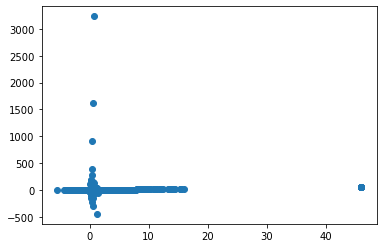

In [491]:
plt.scatter(logits, new_logits)

In [476]:
x = np.linspace(-5, 5, 1000)
Lx = L(x)
plt.plot(1/(1 + np.exp(x)), Lx)

TypeError: gamma_objective() missing 3 required positional arguments: 'se', 'logits', and 'Xb'

In [ ]:
x_best = x[jnp.argmax(Lx)]
x_best, logits[0]
L(x_best), L(logits[0])

hessL(x_best), hessL(logits[0])

x_opt = logits[0]
x_opt = optL(x_opt)
#for _ in range(10):
#    x_opt = optL(x_opt)

gradL(x_opt), gradL(x_best), gradL(logits[0])

(array([2520.,  343.,  264.,  177.,  157.,  121.,  164.,  179.,  234.,
         841.]),
 array([2.8478688e-09, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

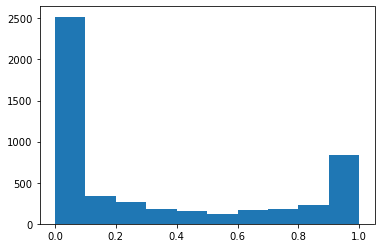

In [256]:
plt.hist(np.array(r))


In [238]:
E1 = e1['data_loglik'] + e1['assignment_entropy'] + e1['susie_loglik']
E2 = e2['data_loglik'] + e2['assignment_entropy'] + e2['susie_loglik']

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.100e+01, 9.300e+01, 9.180e+02,
        3.566e+03, 3.830e+02, 2.000e+01, 5.000e+00]),
 array([-0.01184177, -0.00999022, -0.00813866, -0.0062871 , -0.00443554,
        -0.00258398, -0.00073242,  0.00111914,  0.0029707 ,  0.00482225,
         0.00667381], dtype=float32),
 <BarContainer object of 10 artists>)

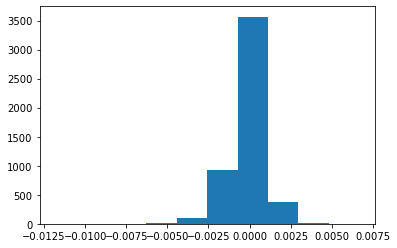

In [239]:
plt.hist(np.array(E2 - E1))

In [190]:
elbo_old = fit2.elbo()
r_old = fit2.data['y']

fit2.update_responsibilities()
elbo_new = fit2.elbo()
r_new = fit2.data['y']

print(is_monotone(fit2.elbo_history))
print(fit2.elbo_history[-1] - fit2.elbo_history[-2])

True
0.4794922


array([-13707.749, -13707.254, -13706.762, -13706.281, -13705.802],
      dtype=float32)

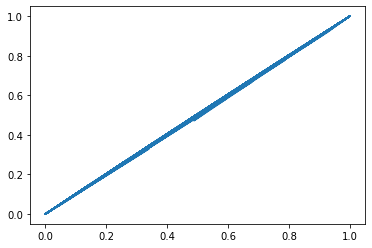

In [191]:
plt.plot(r_old, r_new)
np.array(fit2.elbo_history)[-5:]

In [192]:
elbo_old

{'data_loglik': DeviceArray(-13092.443, dtype=float32),
 'assignment_entropy': DeviceArray(642.60785, dtype=float32),
 'logistic_elbo': DeviceArray(-1255.9655, dtype=float32),
 'total_elbo': DeviceArray(-13705.802, dtype=float32)}

In [194]:
elbo_new

{'data_loglik': DeviceArray(-13095.182, dtype=float32),
 'assignment_entropy': DeviceArray(643.19403, dtype=float32),
 'logistic_elbo': DeviceArray(-1254.7809, dtype=float32),
 'total_elbo': DeviceArray(-13706.769, dtype=float32)}

In [196]:
data = fit2.data
from como.twococomo import twococomo_loglik

def partial_elbo(responsibilities):
    loglik = twococomo_loglik(data, responsibilities, fit2.f0, fit2.f1, sum=False)
    assignment_entropy =  -1 * responsibilities * jnp.log(responsibilities)
    ll_susie = loglik_susie(fit2.data, fit2.logreg.params)
    return loglik, assignment_entropy, ll_susie

l1, a1, s1 = partial_elbo(r_old)
l2, a2, s2 = partial_elbo(r_new)

print(f'Old ELBO: {l1.sum() + a1.sum()}')
print(f'New ELBO: {l2.sum() + a2.sum()}')

fit2.elbo()

Old ELBO: -12449.8359375
New ELBO: -12451.9873046875


{'data_loglik': DeviceArray(-13095.182, dtype=float32),
 'assignment_entropy': DeviceArray(643.19403, dtype=float32),
 'logistic_elbo': DeviceArray(-1254.7809, dtype=float32),
 'total_elbo': DeviceArray(-13706.769, dtype=float32)}

In [179]:
ll1 = l1 + a1 + s1
ll2 = l2 + a2 + s2

np.mean(ll1 <= ll2)

DeviceArray(0.5514, dtype=float32)

In [150]:
from como.twococomo import twococomo_loglik

print(twococomo_loglik(data, data['y'], fit2.f0, fit2.f1))
print(jnp.sum(twococomo_loglik(data, data['y'], fit2.f0, fit2.f1, sum=False)))
print(np.sum(twococomo_loglik(data, data['y'], fit2.f0, fit2.f1, sum=False)))

-13095.181
-13095.181
-13095.181


In [140]:
l2.sum(), a2.sum()

(DeviceArray(-17001.379, dtype=float32), DeviceArray(643.1947, dtype=float32))

In [103]:
fit2.logreg.update()
fit2.elbo_history.append(fit2.elbo()['total_elbo'])

print(is_monotone(fit2.elbo_history))
print(np.array(fit2.elbo_history)[-5:])

True
[-13705.792 -13705.789 -13705.789 -13705.789 -13705.787]


In [104]:
fit2.f0.update(fit2.data)
fit2.elbo_history.append(fit2.elbo()['total_elbo'])
print(is_monotone(fit2.elbo_history))
print(np.array(fit2.elbo_history)[-5:])

True
[-13705.789 -13705.789 -13705.789 -13705.787 -13705.787]


In [105]:
fit2.f1.update(fit2.data)
fit2.elbo_history.append(fit2.elbo()['total_elbo'])
is_monotone(fit2.elbo_history)
is_monotone(fit2.elbo_history)

True

[-13706.281 -13705.802 -13705.796 -13705.796 -13705.796]


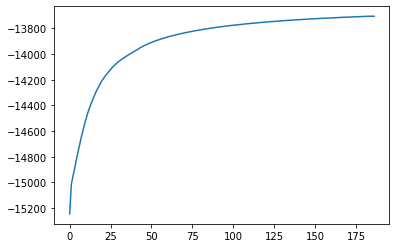

In [91]:
print(np.array(fit2.elbo_history)[-5:])
plt.plot(fit2.elbo_history)

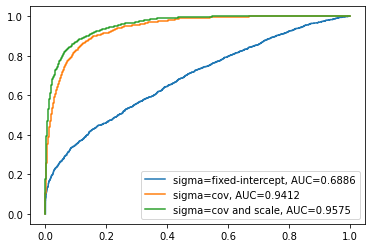

In [24]:
# including te covariates improves the ordering of candidates
# estimating the intercept should improve calibration, but not the ordering
# so we don't see a difference in the ROC curves

plot_roc(y_true,
    [x.responsibilities for x in [fit0a, fit1, fit2]],
    [f'sigma={sigma}' for sigma in ['fixed-intercept', 'cov', 'cov and scale']]
)

In [25]:
(fit2.logreg.params['mu'] * fit2.logreg.params['alpha']).sum(1)

DeviceArray([ 3.2537508e+00,  2.0757973e+00,  9.3113023e-01,
             -7.1558228e-05, -6.7746572e-05, -6.4234526e-05,
             -6.1006940e-05, -5.8030972e-05, -5.5276876e-05,
             -5.2729330e-05], dtype=float32)

Given the correct component distribution we are able to do a great job actually. However, this is a very easy problem... we can make it harder by making it harder to distinguish betwee null/non-null cases.

In [26]:
def threshold(fit, thresh):
    pred = (fit.responsibilities > thresh)
    return pred

def tpr(y_true, fit, thresh):
    pred = threshold(fit, thresh)
    return np.array(((y_true & pred)[pred]).mean())

def fpr(y_true, fit, thresh):
    pred = threshold(fit, thresh)
    return np.array(((~y_true & pred)[pred]).mean())


thresh = 0.5
print(tpr(y_true, fit0a, thresh),  fpr(y_true, fit0a, thresh))
print(tpr(y_true, fit0b, thresh), fpr(y_true, fit0b, thresh))

0.61664844 0.3833516
0.90254235 0.097457625


In [27]:
n = 2000
p = 100
scale = 4.
sim = sim_sumstat_susie(n, p, -4, np.array([2., 4., 6.]), scale=scale)
data = dict(
    beta=sim['beta_hat'], se=sim['se']
)
data_logreg = dict(
    # y=np.random.uniform(size=n), X=sim['X'], Z=sim['Z']
    y=sim['y'], X=sim['X'], Z=sim['Z']
)

data_logreg = dict(
    y=np.random.uniform(sim['y'].size), X=sim['X'], Z=sim['Z']
)

f0 = PointMassComponent(0.0)
f1 = NormalComponent(0, scale)
logreg = LogisticSusie(data_logreg, L=10)
fit = TwoComponentCoMo(data, f0, f1, logreg)
fit_and_plot(fit, niter=1000)

# different z-score thresholds
fit_and_plot_logstic(sim, 1)
fit_and_plot_logstic(sim, 2)
fit_and_plot_logstic(sim, 4)
fit_and_plot_logstic(sim, 8)

NameError: name 'NormalComponent' is not defined

So when it is noisier it is harder to detect (we miss on of the 3 signals). A key question is if we can do better here vs thresholding.

Given the correct componeng distribution, we are able to recover all three signals. In comparison, only the z-score threshold of 2 was able to recover the three signals.

Strikingly, our predictions on the log-odds scale are much better, suggesting that the summary stat model can better recover enrichment effects.

I wonder if there is a way to derive an optimal threshold for recover (given the true component distribution).

On that note, this is not quite a fair assessment yet. We gave the summary stat model the true component distribtions. We ought to be able to learn these....

9.50950950950951


AttributeError: module 'numpy.random' has no attribute 'norma'

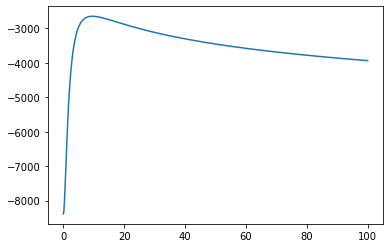

In [286]:
from como.component_distributions import _normal_fixed_loc_objective

scales = np.linspace(0, 100, 1000)
lls = np.array([_normal_fixed_loc_objective(
    fit0a.data['beta'],
    fit0a.data['se'],
    loc=0, scale=scale,
    responsibilities=fit0a.data['y']
) for scale in scales])

plt.plot(scales, lls)

print(scales[np.argmax(lls)])

In [294]:
a = np.random.normal(size = 1000)
b = np.zeros(1000)

np.var(b), np.var(a), np.var(np.concatenate([a, b]))

(0.0, 0.9486440283996519, 0.4743595470233707)

In [277]:
np.linspace(0.1, 10, 100)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])

In [498]:
from como.component_distributions import _normal_fixed_loc_objective
import jax.scipy as jsp

f = lambda x: -1 * _normal_fixed_loc_objective(
    fit2.data['beta'], fit2.data['se'], 0.0, x[0], fit2.data['y'])

vf = jax.vmap(f)

f(np.array([6.0]))
result = jsp.optimize.minimize(f, np.array([1.0]), method='BFGS')
result.x

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2047: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "eye")


DeviceArray([2.3381963], dtype=float32)

In [510]:
fit2.data['y'] = np.random.uniform(size=fit2.data['y'].size)
fit2.f1.scale_grid = np.linspace(0.1, 100, 1000)
fit2.f1.update(fit2.data)
fit2.f1.scale

2.4000000000000004

In [519]:
idx = jnp.argmax(
    vf(fit2.data['beta'], fit2.data['se'], 0.0, fit2.f1.scale_grid, fit2.data['y']))
fit2.f1.scale_grid[idx]

2.4000000000000004

In [461]:
from como.component_distributions import UnimodalNormalMixtureComponent

grid = np.power(2., np.arange(-3, 7)+ 0.0)
pi = np.ones(grid.size) / grid.size

c = UnimodalNormalMixtureComponent()
c.convolved_logpdf(beta, se)


#c.convolved_logpdf(1.0, 1.0)

@jit
def _normal_convolved_logpdf(beta, se, loc, scale):
    scale = jnp.sqrt(se**2 + scale**2)
    return jsp.stats.norm.logpdf(beta-loc, scale=scale)


pdf = vmap(_normal_convolved_logpdf, in_axes=(None, None, None, 0), out_axes=1)
_normal_convolved_logpdf(0, beta, se, 0.2)
pdf(0, beta, se, grid) @ pi

DeviceArray([-2.8788092, -3.4787042, -3.0210245, ..., -3.3344905,
             -2.769044 , -3.6920388], dtype=float32)

In [458]:
from como.component_distributions import _normal_scale_mixture_convolved_pdf, newtonNSM

lossNSM = lambda beta, se, loc, scales, eta:\
     _normal_scale_mixture_convolved_pdf(beta, se, loc, scales, nat2pi(eta)).sum()

L = lambda eta: lossNSM(beta, se, 0, grid, eta)

grid = np.power(2., np.arange(-3, 7)+ 0.0)
eta = np.zeros(grid.size - 1)

lik = [L(eta)]
etas = [eta]
for _ in range(10):
    etas.append(newtonNSM(beta, se, 0, grid, eta))
    lik.append(L(etas[-1]))

etas[2] - etas[3]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [460]:
a = 2 or 1
a

2

### Optimizing the heteroskedastic normal means problem
jax.hes